In [23]:
import omniglot_train_few_shot_no_args as ot
import task_generator_no_args as tg
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')    

In [30]:
import sys
print(f'python : {sys.version}')
print(f'pytorch : {torch.__version__}')

python : 3.8.2 (default, Apr  8 2020, 14:31:25) 
[GCC 9.3.0]
pytorch : 1.4.0


In [2]:
FEATURE_DIM = 64  
RELATION_DIM = 8  
CLASS_NUM = 5  
SAMPLE_NUM_PER_CLASS = 5  
BATCH_NUM_PER_CLASS = 15  
EPISODE = 1000000  
TEST_EPISODE = 1000  
LEARNING_RATE = 0.001  
HIDDEN_UNIT = 10 

# Test just 1 iteration to know how it works

In [3]:
# * Step 1: init data folders
print("init data folders")

# * Init character folders for dataset construction
metatrain_character_folders, metatest_character_folders = tg.omniglot_character_folders()

init data folders


In [4]:
# * Step 2: init neural networks
print("init neural networks")

feature_encoder = ot.CNNEncoder()
relation_network = ot.RelationNetwork(FEATURE_DIM, RELATION_DIM)

feature_encoder.apply(ot.weights_init)
relation_network.apply(ot.weights_init)

feature_encoder.to(device)
relation_network.to(device)
    
feature_encoder_optim = torch.optim.Adam(feature_encoder.parameters(), lr=LEARNING_RATE)
#feature_encoder_scheduler = ot.StepLR(feature_encoder_optim, step_size=100000, gamma=0.5)

relation_network_optim = torch.optim.Adam(relation_network.parameters(), lr=LEARNING_RATE)
#relation_network_scheduler = ot.StepLR(relation_network_optim, step_size=100000, gamma=0.5)

if os.path.exists(str("./models/omniglot_feature_encoder_" + str(CLASS_NUM) + "way_" + str(SAMPLE_NUM_PER_CLASS) + "shot.pkl")):
    feature_encoder.load_state_dict(torch.load(str("./models/omniglot_feature_encoder_" + str(CLASS_NUM) + "way_" + str(SAMPLE_NUM_PER_CLASS) + "shot.pkl")))
    print("load feature encoder success")
if os.path.exists(str("./models/omniglot_relation_network_" + str(CLASS_NUM) + "way_" + str(SAMPLE_NUM_PER_CLASS) + "shot.pkl")):
    relation_network.load_state_dict(torch.load(str("./models/omniglot_relation_network_" + str(CLASS_NUM) + "way_" + str(SAMPLE_NUM_PER_CLASS) + "shot.pkl")))
    print("load relation network success")

init neural networks


In [5]:
episode = 1
#feature_encoder_scheduler.step(episode)
#relation_network_scheduler.step(episode)

# * init dataset
# * sample_dataloader is to obtain previous samples for compare
# * batch_dataloader is to batch samples for training
degrees = random.choice([0, 90, 180, 270])
task = tg.OmniglotTask(metatrain_character_folders, CLASS_NUM, SAMPLE_NUM_PER_CLASS, BATCH_NUM_PER_CLASS)
sample_dataloader = tg.get_data_loader(task, num_per_class=SAMPLE_NUM_PER_CLASS, split="train", shuffle=False, rotation=degrees)
batch_dataloader = tg.get_data_loader(task, num_per_class=BATCH_NUM_PER_CLASS, split="test", shuffle=True, rotation=degrees)

# * sample datas
samples, sample_labels = next(iter(sample_dataloader))  # sample_dataloader.__iter__().next()
batches, batch_labels = next(iter(batch_dataloader))  # batch_dataloader.__iter__().next()

tensor(0)


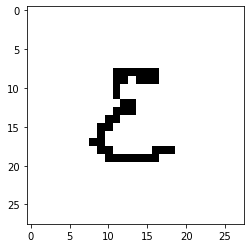

In [6]:
print(sample_labels[0])
plt.imshow(samples[0].reshape(28, 28), cmap='gray')

In [7]:
samples, sample_labels = samples.to(device), sample_labels.to(device)
batches, batch_labels = batches.to(device), batch_labels.to(device)

In [8]:
# * calculates features
sample_features = feature_encoder(samples)
print(sample_features.shape)

torch.Size([25, 64, 5, 5])


In [9]:
sample_features = sample_features.view(CLASS_NUM, SAMPLE_NUM_PER_CLASS, FEATURE_DIM, 5, 5)
print(sample_features.shape)

torch.Size([5, 5, 64, 5, 5])


In [10]:
'''
>>> q = torch.tensor([[[1,2,3], [4,5,6]], [[7, 8, 9], [10, 11, 12]]])
>>> q
tensor([[[ 1,  2,  3],
         [ 4,  5,  6]],

        [[ 7,  8,  9],
         [10, 11, 12]]])
>>> q.shape
torch.Size([2, 2, 3])
>>> torch.sum(q, 1)
tensor([[ 5,  7,  9],
        [17, 19, 21]])
>>> torch.sum(q, 1).squeeze(1)
tensor([[ 5,  7,  9],
        [17, 19, 21]])
'''        
sample_features = torch.sum(sample_features, 1)
print(sample_features.shape)

torch.Size([5, 64, 5, 5])


In [11]:
sample_features = sample_features.squeeze(1)
print(sample_features.shape)

torch.Size([5, 64, 5, 5])


In [12]:
batch_features = feature_encoder(batches)
print(batch_features.shape)

torch.Size([75, 64, 5, 5])


In [13]:
# * calculate relations
# * each batch sample link to every samples to calculate relations
# * to form a 100 * 128 matrix for relation network
sample_features_ext = sample_features.unsqueeze(0)
print(sample_features_ext.shape)

sample_features_ext = sample_features_ext.repeat(BATCH_NUM_PER_CLASS * CLASS_NUM, 1, 1, 1, 1)
print(sample_features_ext.shape)

torch.Size([1, 5, 64, 5, 5])
torch.Size([75, 5, 64, 5, 5])


In [14]:
batch_features_ext = batch_features.unsqueeze(0)
print(batch_features_ext.shape)

batch_features_ext = batch_features_ext.repeat(CLASS_NUM, 1, 1, 1, 1)
print(batch_features_ext.shape)

torch.Size([1, 75, 64, 5, 5])
torch.Size([5, 75, 64, 5, 5])


In [15]:
batch_features_ext = torch.transpose(batch_features_ext, 0, 1)
print(batch_features_ext.shape)

torch.Size([75, 5, 64, 5, 5])


In [16]:
relation_pairs = torch.cat((sample_features_ext, batch_features_ext), 2)
print(relation_pairs.shape)

relation_pairs = relation_pairs.view(-1, FEATURE_DIM * 2, 5, 5)
print(relation_pairs.shape)

torch.Size([75, 5, 128, 5, 5])
torch.Size([375, 128, 5, 5])


In [17]:
relations = relation_network(relation_pairs)
print(relations.shape)

relations = relations.view(-1, CLASS_NUM)
print(relations.shape)

torch.Size([375, 1])
torch.Size([75, 5])


In [18]:
mse = nn.MSELoss()
one_hot_labels = torch.zeros(BATCH_NUM_PER_CLASS * CLASS_NUM, CLASS_NUM).to(device).scatter_(1, batch_labels.view(-1, 1), 1)
loss = mse(relations, one_hot_labels)

In [19]:
print(loss.cpu().detach().numpy())

0.44603148


In [20]:
feature_encoder.zero_grad()
relation_network.zero_grad()

loss.backward()

torch.nn.utils.clip_grad_norm(feature_encoder.parameters(), 0.5)
torch.nn.utils.clip_grad_norm(relation_network.parameters(), 0.5)

feature_encoder_optim.step()
relation_network_optim.step()

In [21]:
print(loss.cpu().detach().numpy())

0.44603148


episode : 10, loss : 0.4160117506980896  
episode : 20, loss : 0.363679438829422  
episode : 30, loss : 0.28375476598739624  

# Test all iterations

In [22]:
print("Training...")

last_accuracy = 0.0

for episode in range(EPISODE):
    
    #feature_encoder_scheduler.step(episode)
    #relation_network_scheduler.step(episode)
    
    # * init dataset
    # * sample_dataloader is to obtain previous samples for compare
    # * batch_dataloader is to batch samples for training
    degrees = random.choice([0, 90, 180, 270])
    task = tg.OmniglotTask(metatrain_character_folders, CLASS_NUM, SAMPLE_NUM_PER_CLASS, BATCH_NUM_PER_CLASS)
    sample_dataloader = tg.get_data_loader(task, num_per_class=SAMPLE_NUM_PER_CLASS, split="train", shuffle=False, rotation=degrees)
    batch_dataloader = tg.get_data_loader(task, num_per_class=BATCH_NUM_PER_CLASS, split="test", shuffle=True, rotation=degrees)
    
    # * sample datas
    # samples, sample_labels = sample_dataloader.__iter__().next()
    # batches, batch_labels = batch_dataloader.__iter__().next()
    
    samples, sample_labels = next(iter(sample_dataloader))
    batches, batch_labels = next(iter(batch_dataloader))
    
    samples, sample_labels = samples.to(device), sample_labels.to(device)
    batches, batch_labels = batches.to(device), batch_labels.to(device)
                    
    # * calculates features
    sample_features = feature_encoder(samples)
    sample_features = sample_features.view(CLASS_NUM, SAMPLE_NUM_PER_CLASS, FEATURE_DIM, 5, 5)
    sample_features = torch.sum(sample_features, 1).squeeze(1)
    batch_features = feature_encoder(batches)
    
    # * calculate relations
    # * each batch sample link to every samples to calculate relations
    # * to form a 100 * 128 matrix for relation network
    sample_features_ext = sample_features.unsqueeze(0).repeat(BATCH_NUM_PER_CLASS * CLASS_NUM, 1, 1, 1, 1)
    batch_features_ext = batch_features.unsqueeze(0).repeat(CLASS_NUM, 1, 1, 1, 1)
    batch_features_ext = torch.transpose(batch_features_ext, 0, 1)
    
    relation_pairs = torch.cat((sample_features_ext, batch_features_ext), 2).view(-1, FEATURE_DIM * 2, 5, 5)
    relations = relation_network(relation_pairs).view(-1, CLASS_NUM)
    
    mse = nn.MSELoss()
    one_hot_labels = torch.zeros(BATCH_NUM_PER_CLASS * CLASS_NUM, CLASS_NUM).to(device).scatter_(1, batch_labels.view(-1, 1), 1)
    loss = mse(relations, one_hot_labels)
    
    feature_encoder.zero_grad()
    relation_network.zero_grad()
    
    loss.backward()
    
    torch.nn.utils.clip_grad_norm(feature_encoder.parameters(), 0.5)
    torch.nn.utils.clip_grad_norm(relation_network.parameters(), 0.5)
    
    feature_encoder_optim.step()
    relation_network_optim.step()
    
    if (episode + 1) % 100 == 0:
        print(f"episode : {episode+1}, loss : {loss.cpu().detach().numpy()}")
        
    if (episode + 1) % 2500 == 0:
        print("Testing...")
        total_reward = 0
        
        for i in range(TEST_EPISODE):
            degrees = random.choice([0, 90, 180, 270])
            task = tg.OmniglotTask(metatest_character_folders, CLASS_NUM, SAMPLE_NUM_PER_CLASS, SAMPLE_NUM_PER_CLASS)
            sample_dataloader = tg.get_data_loader(task, num_per_class=SAMPLE_NUM_PER_CLASS, split="train", shuffle=False, rotation=degrees)
            test_dataloader = tg.get_data_loader(task, num_per_class=SAMPLE_NUM_PER_CLASS, split="test", shuffle=True, rotation=degrees)

            # sample_images, sample_labels = sample_dataloader.__iter__().next()
            # test_images, test_labels = test_dataloader.__iter__().next()            

            sample_images, sample_labels = next(iter(sample_dataloader))
            test_images, test_labels = next(iter(test_dataloader))

            sample_images, sample_labels = sample_images.to(device), sample_labels.to(device)
            test_images, test_labels = test_images.to(device), test_labels.to(device)
                
            # * calculate features
            sample_features = feature_encoder(sample_images)
            sample_features = sample_features.view(CLASS_NUM, SAMPLE_NUM_PER_CLASS, FEATURE_DIM, 5, 5)
            sample_features = torch.sum(sample_features, 1).squeeze(1)
            test_features = feature_encoder(test_images)
            
            # * calculate relations
            # * each batch sample link to every samples to calculate relations
            # * to form a 100x128 matrix for relation network
            
            sample_features_ext = sample_features.unsqueeze(0).repeat(SAMPLE_NUM_PER_CLASS * CLASS_NUM, 1, 1, 1, 1)
            test_features_ext = test_features.unsqueeze(0).repeat(CLASS_NUM, 1, 1, 1, 1)
            test_features_ext = torch.transpose(test_features_ext, 0, 1)         

            relation_pairs = torch.cat((sample_features_ext, test_features_ext), 2).view(-1, FEATURE_DIM * 2, 5, 5)
            relations = relation_network(relation_pairs).view(-1, CLASS_NUM)
            
            _, predict_labels = torch.max(relations.data, 1)
            
            rewards = [1 if predict_labels[j] == test_labels[j] else 0 for j in range(CLASS_NUM * SAMPLE_NUM_PER_CLASS)]
            total_reward += np.sum(rewards)
            
        test_accuracy = total_reward/1.0/CLASS_NUM/SAMPLE_NUM_PER_CLASS/TEST_EPISODE
        # total_reward / (1.0 * CLASS_NUM * SAMPLE_NUM_PER_CLASS * TEST_EPISODE)
        
        print("test accuracy : ", test_accuracy)
        
        if test_accuracy > last_accuracy:
            # save networks
            torch.save(
                feature_encoder.state_dict(),
                str("./models/omniglot_feature_encoder_" + str(CLASS_NUM) + "way_" + str(SAMPLE_NUM_PER_CLASS) + "shot.pkl")
            )

            torch.save(
                relation_network.state_dict(),
                str("./models/omniglot_relation_network_" + str(CLASS_NUM) + "way_" + str(SAMPLE_NUM_PER_CLASS) + "shot.pkl")
            )

            print("save networks for episode:", episode)
            last_accuracy = test_accuracy    

Training...
episode : 100, loss : 0.11256077140569687
episode : 200, loss : 0.08850272744894028
episode : 300, loss : 0.048718616366386414
episode : 400, loss : 0.04328080266714096
episode : 500, loss : 0.029594995081424713
episode : 600, loss : 0.02331722527742386
episode : 700, loss : 0.020142247900366783
episode : 800, loss : 0.010457553900778294
episode : 900, loss : 0.04053056985139847
episode : 1000, loss : 0.009467272087931633
episode : 1100, loss : 0.01664132997393608
episode : 1200, loss : 0.01804373972117901
episode : 1300, loss : 0.04295714199542999
episode : 1400, loss : 0.0034605690743774176
episode : 1500, loss : 0.024324458092451096
episode : 1600, loss : 0.04594869911670685
episode : 1700, loss : 0.008569257333874702
episode : 1800, loss : 0.019227461889386177
episode : 1900, loss : 0.016228288412094116
episode : 2000, loss : 0.0336613766849041
episode : 2100, loss : 0.021473877131938934
episode : 2200, loss : 0.010424191132187843
episode : 2300, loss : 0.02646703086793

KeyboardInterrupt: 